In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import tqdm
import sys
import os
sys.path.append('../..')
from src.features.processing_func import mld
from src.features.processing_func import check_coords, calc_N2_kappa, calc_hab, arctic_calchab, calc_N2_kappa_sorted, mld
from src.features.calc_seaice import calc_SIC
from src.utils.directories import get_parent_directory
from src.features.feature_generation import processing_functions

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
parent_dir = get_parent_directory()

In [55]:
arctic_mix = os.path.join(parent_dir, "data/interim/arctic_mix.nc")
asbo_nc = os.path.join(parent_dir, "data/interim/ASBO-TEACOSI_ds.nc")
mosaic_nc = os.path.join(parent_dir, "data/interim/mosaic_ds.nc")
nice_nc = os.path.join(parent_dir, "data/interim/nice_ds.nc")
HM_nc = os.path.join(parent_dir, "data/interim/HM_ds.nc")
barneo2007_nc = os.path.join(parent_dir, "data/interim/barneo2007_ds.nc")
barneo2008_nc = os.path.join(parent_dir, "data/interim/barneo2008_ds.nc")
KB2018616_nc = os.path.join(parent_dir, "data/interim/KB2018616.nc")
KH2018709_nc = os.path.join(parent_dir, "data/interim/KH2018709.nc")
ascos_nc = os.path.join(parent_dir, "data/interim/ascos_ds.nc")

arctic_ds = xr.open_dataset(arctic_mix)
asbo_ds = xr.open_dataset(asbo_nc)
mosaic_ds = xr.open_dataset(mosaic_nc)
nice_ds = xr.open_dataset(nice_nc)
HM_ds = xr.open_dataset(HM_nc)
barneo2007_ds = xr.open_dataset(barneo2007_nc)
barneo2008_ds = xr.open_dataset(barneo2008_nc)
KB2018616_ds = xr.open_dataset(KB2018616_nc)
KH2018709_ds = xr.open_dataset(KH2018709_nc)
ascos_ds = xr.open_dataset(ascos_nc)

In [56]:
import xarray as xr
arctic_ds = arctic_ds.rename({"longitude": "lon", "latitude": "lat"})
arctic_ds["latitude"] = arctic_ds.lat
arctic_ds["longitude"] = arctic_ds.lon

In [57]:
HM_ds = HM_ds.rename({"time": "time_coor"})
HM_ds["time"] = HM_ds.time_coor

In [59]:
# Bathymetry dataset
GEBCO_ds = os.path.join(parent_dir, "data/external/GEBCO/gebco_2022_n80.0_s63.0_w-170.0_e-130.0.nc")
bathy_ds = xr.open_dataset(GEBCO_ds)

In [60]:
# Sea ice fraction data
SI_HadISST = os.path.join(parent_dir, "data/external/SI-area/HadISST_ice.nc")
Hadi_SI = xr.open_dataset(SI_HadISST)

## Add all features and combine all datasets into one dataframe
The features and the plots are explained below

In [61]:
# add variables of the cruise name
arctic_ds["cruise"] = "ArcticMix"
nice_ds["cruise"] = "NICE-2015"
mosaic_ds["cruise"] = "Mosaic"
HM_ds["cruise"] = "Haakon Mosby"
barneo2007_ds["cruise"] = "IPY Barneo 2007"
barneo2008_ds["cruise"] = "IPY Barneo 2008"
KB2018616_ds["cruise"] = "Nansen Legacy 2018"
KH2018709_ds["cruise"] = "Nansen Legacy 2019"
ascos_ds["cruise"] = "ASCOS"

# asbo cruise name already assigned in preprocessing
# asbo_ds["cruise"] = "ASBO"

In [63]:
asbo_ds["log_eps"] =  np.log10(asbo_ds.eps)
arctic_ds["log_eps"] =  np.log10(arctic_ds.eps)
nice_ds["log_eps"] =  np.log10(nice_ds.eps)
# mosaic already includes eps
mosaic_ds["log_eps"] =  (mosaic_ds.eps)
HM_ds["log_eps"] =  np.log10(HM_ds.eps)
barneo2007_ds["log_eps"] =  np.log10(barneo2007_ds.eps)
barneo2008_ds["log_eps"] =  np.log10(barneo2008_ds.eps)
KB2018616_ds["log_eps"] =  np.log10(KB2018616_ds.eps)
KH2018709_ds["log_eps"] =  np.log10(KH2018709_ds.eps)


In [65]:
selected_columns = ["depth", "profile", "cruise", "latitude", "longitude", "S", "T", "log_eps", "log_N2", "dTdz", "dSdz", "hab", "Tu", "Tu_label", "time", "Rsubrho", "sea_ice_concentration", "MLDJ", "MLDI", "time", "rho", "drhodz"]
# selected_columns = ["depth", "profile", "latitude", "longitude", "P", "S", "T", "Tu", "kappa", "log_N2", "log_kappa", "log_eps", "dTdz", "dSdz", "eps", "cruise", "hab", "Tu_label", "time"]

In [66]:
nice_ds = processing_functions(nice_ds, selected_columns, Hadi_SI, bathy_ds)
nice_df = nice_ds.to_dataframe().reset_index()
nice_df.to_pickle(os.path.join(parent_dir, "data/interim/nice_df.pkl"))

In [67]:
mosaic_ds = processing_functions(mosaic_ds, selected_columns, Hadi_SI, bathy_ds)
mosaic_df = mosaic_ds.to_dataframe().reset_index()
mosaic_df.to_pickle(os.path.join(parent_dir, "data/interim/mosaic_df.pkl"))

In [68]:
HM_ds = processing_functions(HM_ds, selected_columns, Hadi_SI, bathy_ds)
HM_df = HM_ds.to_dataframe().reset_index()
HM_df.to_pickle(os.path.join(parent_dir, "data/interim/HM_df.pkl"))

In [7]:
selected_columns = ["depth", "profile", "cruise", "latitude", "longitude", "S", "T", "log_eps", "log_N2", "dTdz", "dSdz", "hab", "Tu", "Tu_label", "time", "Rsubrho", "sea_ice_concentration", "MLDJ", "MLDI", "time", "rho", "drhodz"]

In [69]:
asbo_ds = processing_functions(asbo_ds, selected_columns, Hadi_SI, bathy_ds, ASBO=True)

# Assuming you have the density (rho), salinity (S), and temperature (T) values
rho = asbo_ds['rho'].values
S = asbo_ds['S'].values
T = asbo_ds['T'].values

# Calculate the vertical gradients of potential density
drhodS = np.diff(rho, axis=0) / np.diff(S, axis=0)[:, :]
drhodT = np.diff(rho, axis=0) / np.diff(T, axis=0)[:, :]

# Add NaN values at the end of each depth
drhodS = np.concatenate((drhodS, np.nan*np.ones((1, drhodS.shape[1]))), axis=0)
drhodT = np.concatenate((drhodT, np.nan*np.ones((1, drhodT.shape[1]))), axis=0)

# Calculate the density ratio
Rho_ratio = drhodS / drhodT

# Assign Rho_ratio to a new variable in the dataset
asbo_ds["Rsubrho"] = (("depth", "profile"), Rho_ratio)

# Assuming you have the salinity (S), temperature (T), and depth values
S = asbo_ds['S'].values
T = asbo_ds['T'].values
depth = asbo_ds['depth'].values

# Create a sorting index based on NaN values in temperature for each profile
sort_indices = np.argsort(np.isnan(T), axis=0)

# Initialize sorted_S and sorted_T arrays
sorted_S = np.empty_like(S)
sorted_T = np.empty_like(T)

# Loop through each profile and sort the salinity and temperature values along the depth dimension
for profile in range(S.shape[1]):
    sorted_S[:, profile] = np.take(S[:, profile], sort_indices[:, profile])
    sorted_T[:, profile] = np.take(T[:, profile], sort_indices[:, profile])

# Sort the depth array using the sorting index
sorted_depth = np.take(depth, sort_indices, axis=0)

# Calculate the potential density using sorted salinity and temperature
rho = gsw.rho(sorted_S, sorted_T, 0)

# Calculate the vertical gradient of sorted potential density
drhodz = np.diff(rho, axis=0) / np.diff(sorted_depth, axis=0)

# Calculate the second vertical derivative of sorted potential density
d2rhodz2 = np.diff(drhodz, axis=0) / np.diff(sorted_depth[:-1], axis=0)

# Calculate the background buoyancy frequency
g = 9.81  # acceleration due to gravity (m/s^2)
# Add NaN values for the first and last depth level of rho
# rho = np.concatenate(([np.nan], rho, [np.nan]))
N2_bg = (g / rho[1:-1]) * d2rhodz2

# Add NaN values for the first and last depth level of N2_bg
nan_array = np.empty((1,) + N2_bg.shape[1:])
nan_array[:] = np.nan
N2_bg = np.concatenate((nan_array, N2_bg, nan_array), axis=0)

# Assign log of background buoyancy frequency to a new variable in the dataset
asbo_ds["log_N2"] = (("depth", "profile"), np.log(N2_bg))


asbo_df = asbo_ds.to_dataframe().reset_index()

# Different way of calculating N2 that does not generate as many NaNs
# formula from https://www.sciencedirect.com/book/9780127329512/atmospheric-science
# g = 9.81 # gravitational acceleration
# asbo_df["N2"] = ((g/asbo_df["rho"]) * asbo_df["drhodz"])**0.5
# asbo_df["log_N2"] = np.log10(asbo_df["N2"])

# Calculate the Turner angle
asbo_df["Tu"] = np.arctan(asbo_df["dSdz"] / asbo_df["dTdz"])

asbo_df.to_pickle(os.path.join(parent_dir, "data/interim/asbo_df.pkl"))

In [70]:
barneo2007_ds = processing_functions(barneo2007_ds, selected_columns, Hadi_SI, bathy_ds)
barneo2007_df = barneo2007_ds.to_dataframe().reset_index()
barneo2007_df.to_pickle(os.path.join(parent_dir, "data/interim/barneo2007_df.pkl"))
barneo2008_df = processing_functions(barneo2008_ds, selected_columns, Hadi_SI, bathy_ds)
barneo2008_df = barneo2008_ds.to_dataframe().reset_index()
barneo2008_df.to_pickle(os.path.join(parent_dir, "data/interim/barneo2008_df.pkl"))

KB2018616_ds = processing_functions(KB2018616_ds, selected_columns, Hadi_SI, bathy_ds)
KB2018616_df = KB2018616_ds.to_dataframe().reset_index()
KB2018616_df.to_pickle(os.path.join(parent_dir, "data/interim/KB2018616_df.pkl"))
KH2018709_ds = processing_functions(KH2018709_ds, selected_columns, Hadi_SI, bathy_ds)
KH2018709_df = KH2018709_ds.to_dataframe().reset_index()
KH2018709_df.to_pickle(os.path.join(parent_dir, "data/interim/KH2018709_df.pkl"))

In [71]:
ascos_ds = processing_functions(ascos_ds, selected_columns, Hadi_SI, bathy_ds)
ascos_df = ascos_ds.to_dataframe().reset_index()
ascos_df.to_pickle(os.path.join(parent_dir, "data/interim/ascos_df.pkl"))

In [80]:
arctic_ds["sea_ice_concentration"] = 0
arctic_ds = processing_functions(arctic_ds, selected_columns, Hadi_SI, bathy_ds, True)
arctic_df = arctic_ds.to_dataframe().reset_index()
arctic_df.to_pickle(os.path.join(parent_dir, "data/interim/arctic_df.pkl"))

## Open saved dataframes

In [81]:
arctic_df = pd.read_pickle(os.path.join(parent_dir, "data/interim/arctic_df.pkl"))
nice_df = pd.read_pickle(os.path.join(parent_dir, "data/interim/nice_df.pkl"))
mosaic_df = pd.read_pickle(os.path.join(parent_dir, "data/interim/mosaic_df.pkl"))
ascos_df = pd.read_pickle(os.path.join(parent_dir, "data/interim/ascos_df.pkl"))
asbo_df = pd.read_pickle(os.path.join(parent_dir, "data/interim/asbo_df.pkl"))
HM_df = pd.read_pickle(os.path.join(parent_dir, "data/interim/HM_df.pkl"))
barneo2007_df = pd.read_pickle(os.path.join(parent_dir, "data/interim/barneo2007_df.pkl"))
barneo2008_df = pd.read_pickle(os.path.join(parent_dir, "data/interim/barneo2008_df.pkl"))
KB2018616_df = pd.read_pickle(os.path.join(parent_dir, "data/interim/KB2018616_df.pkl"))
KH2018709_df = pd.read_pickle(os.path.join(parent_dir, "data/interim/KH2018709_df.pkl"))

In [5]:
combined_df = pd.concat([nice_df,arctic_df, mosaic_df, HM_df, asbo_df, barneo2007_df, barneo2008_df, KB2018616_df, KH2018709_df, ascos_df])
combined_nona = combined_df.dropna()
combined_nona.to_pickle(os.path.join(parent_dir, "data/processed/ml_ready/2706_ML.pkl"))

In [84]:
dfs = [nice_df,arctic_df, mosaic_df, HM_df, asbo_df, barneo2007_df, barneo2008_df, KB2018616_df, KH2018709_df, ascos_df]

In [82]:
selected_columns = ["depth", "profile", "cruise", "latitude", "longitude", "S", "T", "log_eps", "log_N2", "dTdz", "dSdz", "hab", "Tu", "Tu_label", "Rsubrho", "sea_ice_concentration", "MLDJ", "MLDI"]
selected_columns_time = ["depth", "profile", "cruise", "latitude", "longitude", "S", "T", "log_eps", "log_N2", "dTdz", "dSdz", "hab", "Tu", "Tu_label", "Rsubrho", "sea_ice_concentration", "MLDJ", "MLDI", "time"]

In [160]:
# Select columns from each DataFrame and concatenate them
# combined_df = pd.concat([df[selected_columns] for df in dfs])
# combined_nona = combined_df.dropna()
# combined_nona.to_pickle(os.path.join(parent_dir, "data/processed/ml_ready/2706_ML.pkl"))

In [85]:
# Select columns from each DataFrame and concatenate thems
selected_columns_time = ["depth", "profile", "cruise", "latitude", "longitude", "S", "T", "log_eps", "log_N2", "dTdz", "dSdz", "hab", "Tu", "Tu_label", "Rsubrho", "sea_ice_concentration", "MLDJ", "MLDI", "time"]
combined_df_time = pd.concat([df[selected_columns_time] for df in dfs])

# Convert 'inf' and '-inf' to 'NaN'
combined_df_time = combined_df_time.replace([np.inf, -np.inf], np.nan)

combined_nona_time = combined_df_time.dropna()
combined_nona_time.to_pickle(os.path.join(parent_dir, "data/processed/ml_ready/2706_time.pkl"))

In [60]:
import joblib

# Save data using joblib
joblib.dump(combined_nona_time, os.path.join(parent_dir, "data/processed/ml_ready/1906_time.pkl"))

['/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed/ml_ready/1906_time.pkl']

In [65]:
path = os.path.join(parent_dir, "data/processed/ml_ready/1906_time.pkl")

In [67]:
combined_nona_time.to_pickle(path)

In [68]:
hallo = pd.read_pickle(path)

In [55]:
# Load data using joblib
loaded_data = joblib.load(os.path.join(parent_dir, "data/processed/ml_ready/1906_time.sav"))

# Evaluate nice_ds features

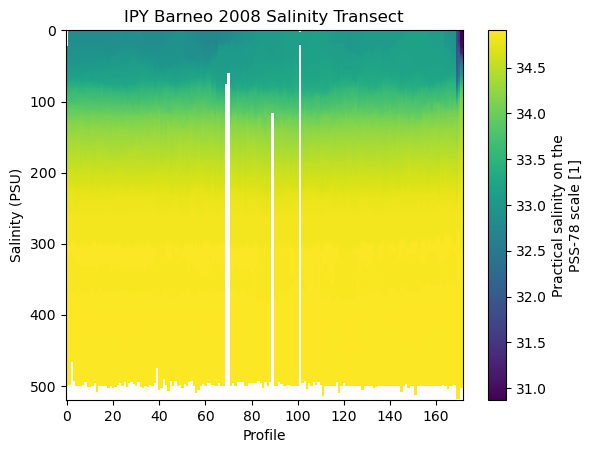

In [142]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.S.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Practical salinity') # dimensionless
plt.title('IPY Barneo 2008 Salinity Transect')
plt.show()

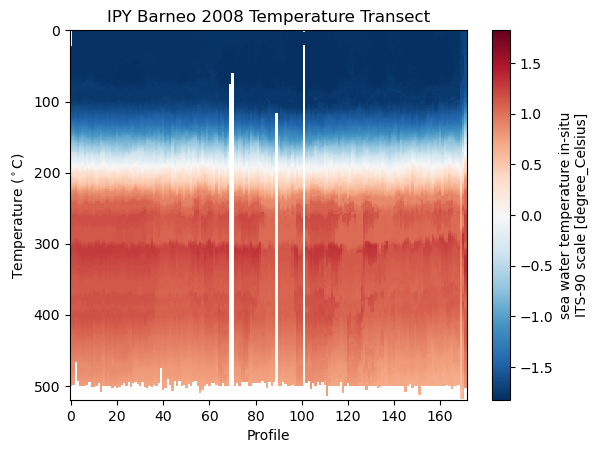

In [144]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.T.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('IPY Barneo 2008 Temperature Transect')
plt.show()

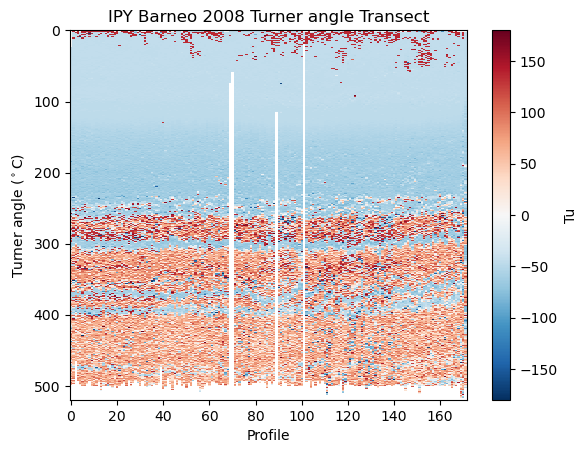

In [18]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.Tu.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

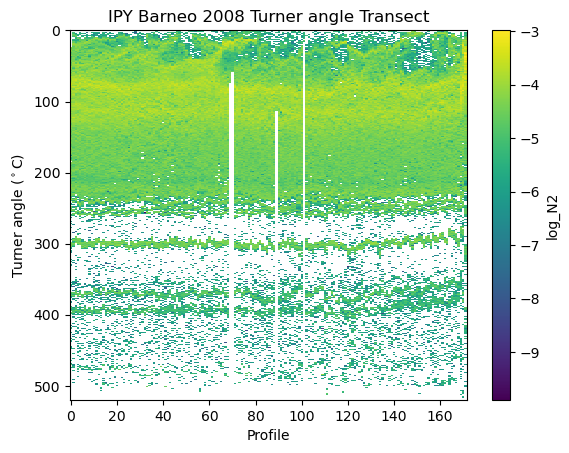

In [22]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.log_N2.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

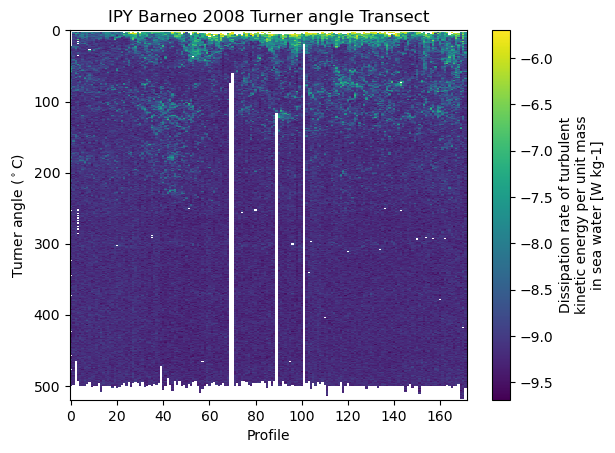

In [23]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.log_eps.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

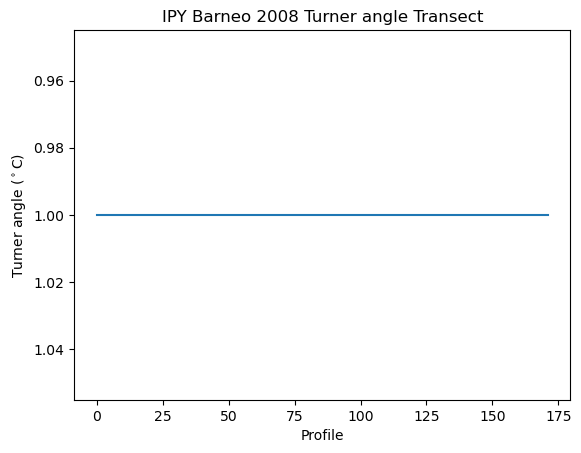

In [24]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.sea_ice_concentration.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

In [27]:
barneo2008_ds.Rsubrho.values

array([[            nan, -1.45531100e-03,             nan, ...,
                    nan,             nan,             nan],
       [            nan, -1.30063404e-03,             nan, ...,
                    nan,             nan,             nan],
       [            nan,  6.20935962e-03,  4.18437751e-04, ...,
        -5.39027030e-05, -4.53278819e-03, -1.26954509e-03],
       ...,
       [            nan,             nan,             nan, ...,
        -4.81694090e-01,  1.00230824e+00,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])

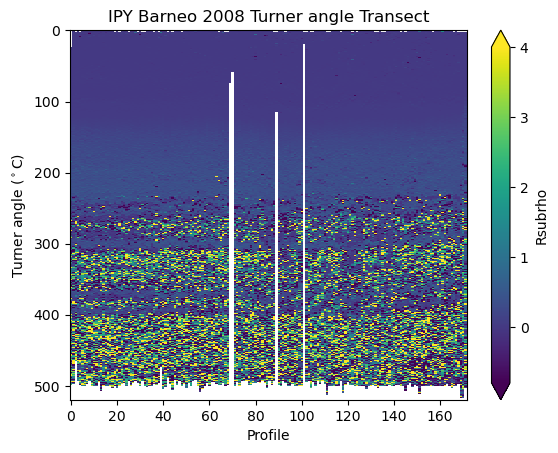

In [38]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.Rsubrho.plot(vmin=-0.8, vmax=4)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

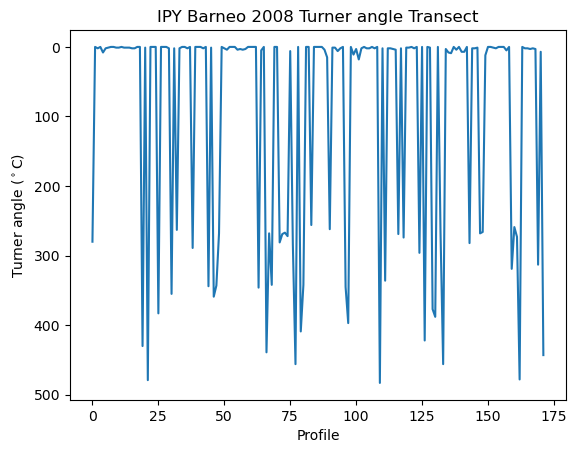

In [40]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.MLDI.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

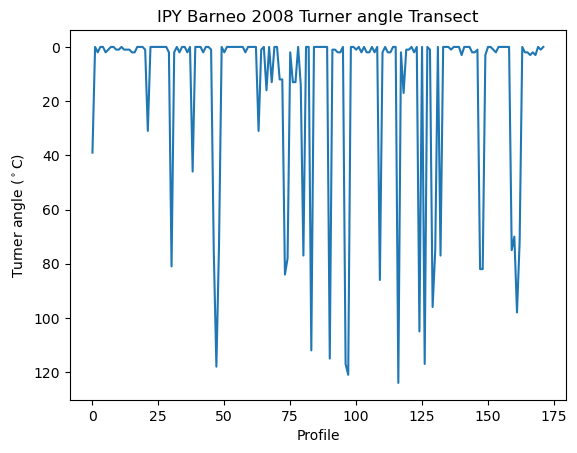

In [41]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.MLDJ.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

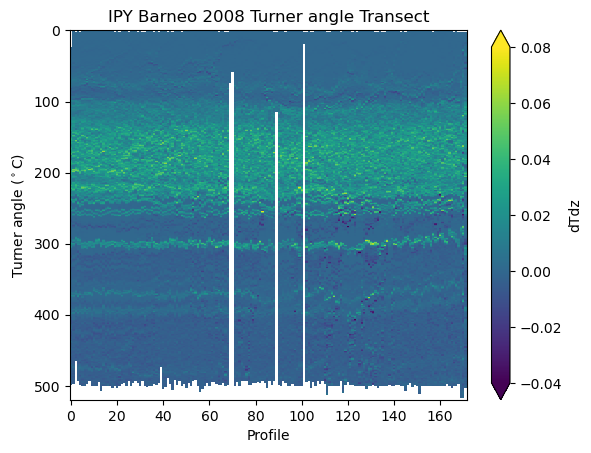

In [53]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.dTdz.plot(vmin=-.04, vmax=0.08)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

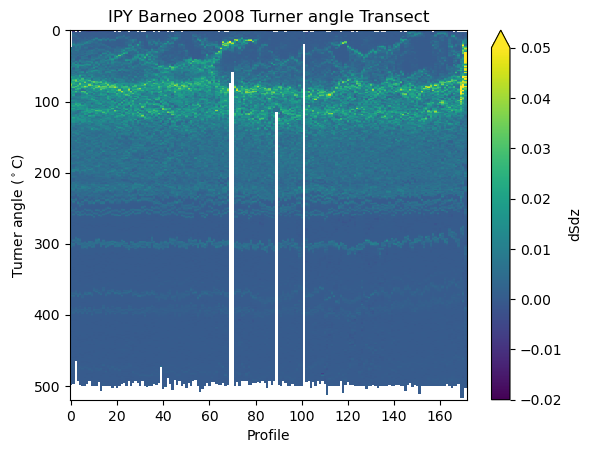

In [54]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.dSdz.plot(vmin = -0.02, vmax=0.05)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

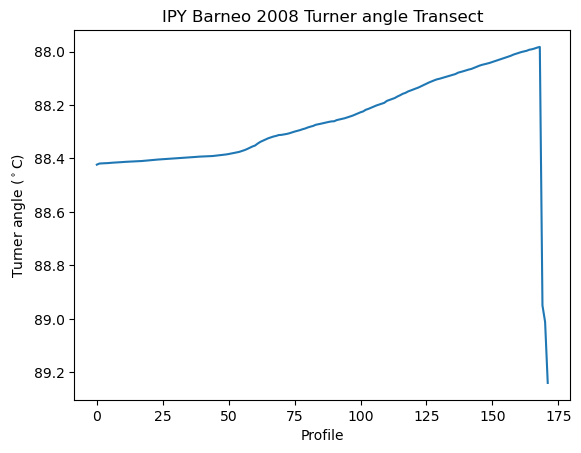

In [55]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.latitude.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

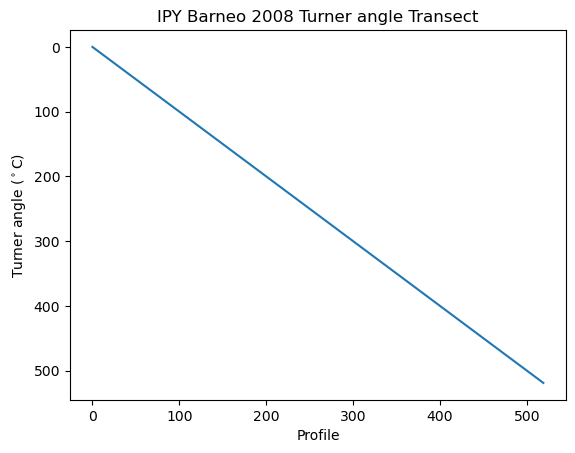

In [56]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.depth.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Turner angle ($^\circ$C)')
plt.title('IPY Barneo 2008 Turner angle Transect')
plt.show()

In [15]:
barneo2008_ds

<xarray.Dataset>
Dimensions:                (profile: 172, depth: 520)
Dimensions without coordinates: profile, depth
Data variables: (12/30)
    latitude               (profile) float64 88.42 88.42 88.42 ... 89.01 89.24
    longitude              (profile) float64 7.734 7.635 7.595 ... -104.9 -90.4
    P                      (depth) float64 1.0 2.0 3.0 4.0 ... 518.0 519.0 520.0
    T                      (depth, profile) float64 nan -1.797 nan ... nan nan
    S                      (depth, profile) float64 nan 32.84 nan ... nan nan
    eps                    (depth, profile) float64 nan nan nan ... nan nan nan
    ...                     ...
    log_kappa              (depth, profile) float64 nan nan nan ... nan nan nan
    log_eps                (depth, profile) float64 nan nan nan ... nan nan nan
    dTdz                   (depth, profile) float64 nan 0.0005559 ... nan nan
    dSdz                   (depth, profile) float64 nan -0.01071 nan ... nan nan
    bathymetry             (profile) float64 -3.36e+03 -3.36e+03 ... -3.36e+03
    hab                    (profile, depth) float64 -3.36e+03 ... -2.841e+03
Attributes: (12/41)
    title:                         Vertical microstructure profiles from a dr...
    history:                       Version 1
    summary:                       Ocean microstructure profiles were collect...
    comment:                       Microstructure profiles were collected bet...
    type:                          1-m vertically averaged microstructure pro...
    creation_time:                 2023-06-13T09:40:50Z
    ...                            ...
    citation:                      Fer, Ilker (2023), Vertical microstructure...
    instrument:                    MSS90L
    instrument_serial_number:      33
    instrument_sample_rate:        1024.0
    instrument_sampling_mode:      continuous
    profiling_direction:           down

In [151]:
import matplotlib.pyplot as plt

# Plotting the 'S' column with inverted y-axis
barneo2008_ds.hab.plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Profile')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('IPY Barneo 2008 Temperature Transect')
plt.show()

AttributeError: 'Dataset' object has no attribute 'hab'